# Assignment 3(B): Building a Robot Cleaner with Reinforcement Learning

### Acknowledgment

You are required to acknowledge the following statement by entering your full name, SID, and date below:

"By continuing to work on or submit this deliverable, I acknowledge that my submission is entirely my independent original work done exclusively for this assessment item. I agree to: 

* Submit only my independent original work
* Not share answers and content of this assessment with others
* Report suspected violations to the instructor

Furthermore, I acknowledge that I have not engaged and will not engage in any activities that dishonestly improve my results or dishonestly improve/hurt the results of others, and that I abide to all academic honor codes set by the University."

**Your full name:** removed

**Your SID:** removed

**Date:** 21 Jul 2022

## 1. Introduction <a id='section_1'></a>
In this part of the assignment, you will implement the Reinforcement Learning (RL) algorithms, and use the models learned by these algorithms to make decisions on cleaning robot navigation problem. You are required to complete the lines between __START YOUR CODE HERE__ and __END YOUR CODE HERE__ (if applicable) and to execute each cell. Within each coding block, you are required to enter your code to replace `None` after the `=` sign (except otherwise stated). You are not allowed to use other libraries or files than those provided in this assignment. When entering your code, you should not change the names of variables, constants, and functions already listed. 

**Contents**

* [1. Introduction](#section_1)
* [2. Learning Environment](#section_2)
* [3. Q-Agent](#section_3)
* [4. Agent Environment Interaction](#section_4)
* [5. Cleaning Performance Evaluation](#section_5)
    * [5.1. Empty Room with One Cell to Clean](#section_51)
    * [5.2. Empty Room with Two Cells to Clean](#section_52)
    * [5.3. Room with Obstacles and Two Cells to Clean](#section_53)
* [6. Marking Scheme and Submission](#section_6)
* [7. Summary](#section_7)

Before we begin with the exercises, we need to import all libraries required for this programming exercise.

In [312]:
# Scientific and vector computation for python
import numpy as np

# Plotting library
import matplotlib.pyplot as plt 

# library for data copy
from copy import deepcopy

# package for display
from IPython import display

# the Room environment
import Room
from Room import *

# tells matplotlib to embed plots within the notebook
%matplotlib inline

## 2. Learning Environment <a id='section_2'></a>
You will use a pre-defined environment (a room) to train a robot (or agent) to learn to clean a room. The robot has a set of sensors to observe the state of its environment, and a set of actions it can perform to change the state. You will implement a reinforcement learning (RL) algorithm to enable the robot to learn. The environment (the class named "Room()") has been set up for you as follows.

![Room Environment](./room.png "Room")

1. **Grid**: the room is split into 49 (=7x7) cells. The position of the robot cleaner must be in one of these cells.
2. **Goal**: the goal of the robot (green circle) is to clean all the cell(s) labeled with **red stars** by minimizing the energy to be used to navigate to the cell(s) (assuming unlimited battery capacity). 
3. **Obstacle**: each obstacle is labeled by a **black cell** that the robot should avoid colliding with.

All agents will learn by interacting with the environment. You can create and initialize such the environment (room) with the following statement:
```
    env = Room(size=(5,5), goal_num=3, obstacle_num=2)
```
where the input `size=` denotes the configuration of the room; "goal_num" is the number of cells (labeled with stars) that the robot should clean; "obstacle_num" is the number of obstacles. After you initialized the environment named by `env`, you can use three types of functions:

1. `env.reset()`: this function is used to reset the room environment. The positions of the robot and goals will be re-assigned randomly. The output of this function is the `state` vector (i.e., states).
2. `env.step()`: is used to let the agent interact with the environment. The agent enters `action` to the function that returns the `state` and `reward`. The boolean parameter `done` indicates whether the learning episode is ending (if it happens, then the function "env.reset()" must be used to reset the environment).
3. `env.render()`: is used to visualize the current situation of environment (grid world), goal cells (red star) and your cleaning robot (green circle).

##### Reward Computation
1. energy usage: a penalty $r_{energy} = -0.01$ will be incurred each time the `env.step()` is used.
2. reaching a goal: when the robot reaches a goal, a reward $r_{goal} = +1$ will be added and the color of goal star will turn from red to blue (no more reward will be given when it is re-visited). If all goals have been reached, then the learning episode will end.
3. boundary penalty: any action that will lead the robot to go out of the room boundary will incur a penalty $r_{boundary} = -0.01$, and the robot will stay in the cell prior to taking this action.
4. obstacle penalty: when the robot collide with an obstacle, a penalty $r_{obstacle} = -1$ will be incurred. Then, this episode will end. 


**[Test Block 1]:** Test code for class `Room()`.
After defining the environment, please run the following demo `room_0 = Room()`environment to see how the robot interacts with the environment. 

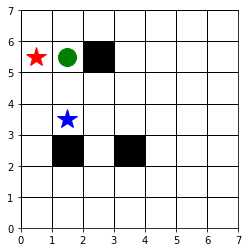

In [313]:
# random robot cleaning
fig = plt.figure(figsize=(6,6))
ax = fig.subplots(1,1)
room_0 = Room(goal_num=2, obstacle_num=3)
state = room_0.reset()

for _ in range(100):
    action = np.random.randint(room_0.action_space)
    state, reward, done = room_0.step(action)
    room_0.render()
    plt.pause(0.01)
    display.clear_output(wait=True)
    if done:
        state = room_0.reset()

## 3. Q-Agent <a id='section_3'></a>
One of the most important tasks to use reinforcement learning is to define a learning agent. In this assignment, your task is to implement the Q-learning algorithm. The update rule of Q-learning algorithm is defined as follows:

$$ \hat{Q}(s, a) \leftarrow r + \gamma\max_{a^{\prime}}\hat{Q}(s^{\prime}, a^{\prime}) \ . \tag{1}$$ 

**Task 1:** <a id='task_1'></a> in detail, you should:

1. assign the input `gamma` to attribute `self.gamma` (1 line)
2. assign the input `learning_rate` to attribute `self.learning_rate` (1 line)
3. assign the input `epsilon` to attribute `self.epsilon` (1 line)

**Task 2:** <a id='task_2'></a> In this task, you will implement the [$\epsilon$-greedy](https://stanford-cs221.github.io/autumn2020-extra/modules/mdps/epsilon-greedy.pdf) rule for the exploration and exploitation in an unknown environment ([this article provides a practical explanation of the algorithm](https://moodle.hku.hk/mod/resource/view.php?id=2589880)).

1. generate a random number in uniform distribution between 0 and 1. You can use the function `np.random.uniform()` to generate this number and compare this number with `self.epsilon`. (1 line)
2. if the number is larger than the `self.epsilon`, you will get current action value based on the current state of Q table. To do so, you will (3 lines)
    * transform the list data type of `state` to tuple with the function `tuple()`. Save it in `tuple_state`.
    * use `self.q_table[]` and `tuple_state` to get the q value vector of current state. Save it in `q_value`.
    * extract the element index of the maximal value in the `q_value`. Save it in `action`. The function [`np.argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) can be applied to a numpy array to find the maximal value among all its values.
3. if the number is smaller than `self.epsilon`, then you will select one action from [0, 1, 2, 3] randomly (note: `self.action_n` = 4, i.e., four possible actions). You can use the `np.random.randint()` to finish this function. (1 line)

**Task 3:** <a id='task_3'></a> In this task, you will:

1. compute `td_target` by applying the updating rule of Q-learning (Equation (1)) to get next state's estimated reward (note: you can use `.max()` to find the maximum scalar value within a numpy array; you need to multiply `(1 - done)` with the $\max$ function in Equation (1)) (1 line)
2. assign `state` to `q_state` and append `action` to `q_state` (2 lines)
3. compute `td_error` by subtracting the reward of current state and action (by using the `self.q_table`) from `td_target` (hint: see `q_value` in Task 2) (1 line)
4. update the Q-table of current state by adding the product of learning rate and `td_error` (1 line)

In [314]:
class QAgent:
    def __init__(self, env, gamma=0.9, learning_rate=0.1, epsilon=0.2):
        '''
            - env: environment for learning
            - gamma: reward discount factor
            - learning_rate: learning rate
            - epsilon: hyperparameter for exploration
        '''
        # task 1:
        # ====================== START YOUR CODE HERE ======================
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        # ====================== END YOUR CODE HERE ========================
        self.action_n = env.action_space
        # q-table
        q_table_dimension = env.state_space
        q_table_dimension.append(env.action_space)
        self.q_table = np.random.normal(0.0, 0.0001, q_table_dimension) 
    def decide(self, state):
        # task 2:
        # ====================== START YOUR CODE HERE ======================
        if np.random.uniform() > self.epsilon:
            tuple_state = tuple(state)
            q_value = self.q_table[tuple_state]
            action = np.argmax(q_value)
        else:
            action = np.random.randint(4)
        # ====================== END YOUR CODE HERE ========================
        return action
    
    def learn(self, state, action, reward, next_state, done):
        # task 3:
        # ====================== START YOUR CODE HERE ======================
        td_target = reward + self.gamma * ((self.q_table[tuple(next_state)]).max()) * (1-done)
        q_state = state
        q_state.append(action)
        td_error = td_target - self.q_table[tuple(q_state)]
        self.q_table[tuple(q_state)] += self.learning_rate * td_error
        # ====================== END YOUR CODE HERE ========================

## 4. Agent-Environment Interaction <a id='section_4'></a>
In this part, you will define the function for the interaction between agent and environment. In detail, you will:

**Task 4:** <a id='task_4'></a>

1. get the current action from the agent with its function `decide()`. Save the resulting action in `action` (1 line)
2. use the `action` as input to the function `env.step()` to generate `next_state`, `reward`, and `done` (check if the current state is a terminal state of this episode) (1 line)
3. store the obtained `reward` in `episode_reward` (1 line)

**Task 5:** <a id='task_5'></a> 

1. when `train` is true, please use your implemented `agent.learn()` function to update the Q-table in the agent with existing variables as inputs (1 line)

In [315]:
def agent_env_interaction(env, agent, max_iter=50, train=False):
    episode_reward = 0
    state = env.reset()
    for _ in range(max_iter):
        # task 4:
        # ====================== START YOUR CODE HERE ======================
        action = agent.decide(state)
        next_state, reward, done = env.step(action)
        #print(next_state, reward, done)
        episode_reward += reward
        #print(episode_reward)
        # ====================== END YOUR CODE HERE ========================
        if train:
            # task 5:
            # ====================== START YOUR CODE HERE ======================
            agent.learn(state, action, reward, next_state, done)
            # ====================== END YOUR CODE HERE ========================
        if done:
            break
        state = next_state
    return episode_reward

## 5. Cleaning Performance Evaluation <a id='section_5'></a>
In this section, you will train multiple agents in different environments. Note that the agents cannot guarantee 100% successful completion of the tasks. You can re-run the evaluation to watch the overall performance of the agent. 
### 5.1. Empty Room with One Cell to Clean<a id='section_51'></a>
#### 5.1.1. Training Environment Setting <a id='section_511'></a>
The learning task is to let the robot clean one target cell in an empty room (without obstacle). The environment will be configured to have one goal and no obstacle. In detail, you will:

**Task 6:** <a id='task_6'></a> 
##### Task 6(A)
1. create a `Room()` environment and save it in `room_1`. Please set the input `goal_num=` and `obstacle_num=` correctly. (1 line)
2. create a `QAgent()` robot and save it in `robot_1`. Please set the input `epsilon=` as 0.2 (you can also set another value later for comparison). (1 line)
##### Task 6(B)
3. get the reward of one episode with your implemented function `agent_env_interaction()`. Do not forget to set the input `train=` to be `True`. Then, save the result in `episode_reward`. (1 line)

In [329]:
episodes = 10000
#episodes = 100
# create environment
# task 6(A):
# ====================== START YOUR CODE HERE ======================
room_1 = Room(goal_num=1, obstacle_num=0)
robot_1 = QAgent(room_1, epsilon=0.2)
# ====================== END YOUR CODE HERE ========================
# training
episode_rewards = []
for episode in range(episodes):
    if episode % 1000 == 0:
        print("Episode: {}".format(episode))
    # task 6(B):
    # ====================== START YOUR CODE HERE ======================
    episode_reward = agent_env_interaction(room_1, robot_1, max_iter=50, train=True)
    # ====================== END YOUR CODE HERE ========================
    episode_rewards.append(episode_reward)

Episode: 0
Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000


#### 5.1.2. Training Performance Visualization <a id='section_512'></a>
After training 10000 episodes, the average rewards of each episode are visualized by the following figure. Note that we use a moving average (window size=20) on the recorded reward information. Decreasing the size of the window would show a more drastic fluctuation of rewards during the learning process.

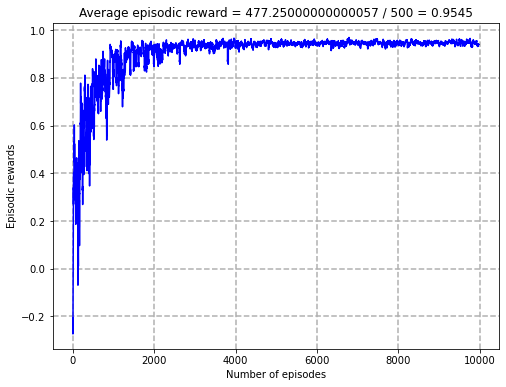

In [330]:
# compute moving average
window_size = 20
moving_averaged_rewards = list()
for idx in range(len(episode_rewards)):
    if idx+window_size < len(episode_rewards):
        average_reward = np.mean(episode_rewards[idx:idx+window_size])
        moving_averaged_rewards.append(average_reward)

# test agent without exploration
robot_1.epsilon = 0.0
test_episode_rewards = [agent_env_interaction(room_1, robot_1, train=False) for _ in range(500)]
#test_episode_rewards = [agent_env_interaction(room_1, robot_1, train=False) for _ in range(100)]

fig = plt.figure(figsize=(8,6))
ax = fig.subplots(1,1)
ax.plot(moving_averaged_rewards, color='b', linewidth=1.5)
ax.grid(linestyle='--', linewidth=1.5)
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Episodic rewards')
ax.set_title('Average episodic reward = {} / {} = {}'.format(sum(test_episode_rewards), 
                                                              len(test_episode_rewards), np.mean(test_episode_rewards)));

#### 5.1.3. Robot Behavior Visualization <a id='section_513'></a>
You can also visualize the behaviors of your trained cleaning robot in the room by the following code block:  

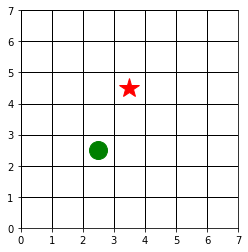

In [331]:
# robot clearning with single goal
state = room_1.reset()
for _ in range(100):
    action = robot_1.decide(state)
    state, reward, done = room_1.step(action)    
    room_1.render()
    plt.pause(0.01)
    display.clear_output(wait=True)
    if done:
        state = room_1.reset()

### 5.2. Empty Room with Two Cells to Clean <a id='section_52'></a>
#### 5.2.1. Training Environment Setting <a id='section_521'></a>
The learning task in this section is to let the robot clean two target cells in an empty room (without obstacle). The environment will be configured to have two goals and no obstacle. In detail, you will:

**Task 7:** <a id='task_7'></a> 
##### Task 7(A)
1. create a `Room()` environment and save it in `room_2`. Please set the input `goal_num=` and `obstacle_num=` correctly. (1 line)
2. create a `QAgent()` robot and save it in `robot_2`. Please set the input `epsilon=` as 0.2 (you can also set another value later for comparison). (1 line)
##### Task 7(B)
3. get the reward of one episode with your implemented function `agent_env_interaction()`. Do not forget to set the input `train=` to be `True`. Then, save the result in `episode_reward`. (1 line)

This part requires aproximately 4-6 minutes depending on your hardware.

In [336]:
episodes = 100000
# create environment
# task 7(A):
# ====================== START YOUR CODE HERE ======================
room_2 = Room(goal_num=2, obstacle_num=0)
robot_2 = QAgent(room_2, epsilon=0.2)
# ====================== END YOUR CODE HERE ========================
# training
episode_rewards = []
for episode in range(episodes):
    if episode % 1000 == 0:
        print("Episode: {}".format(episode))
    # task 7(B):
    # ====================== START YOUR CODE HERE ======================
    episode_reward = agent_env_interaction(room_2, robot_2, max_iter=50, train=True)
    # ====================== END YOUR CODE HERE ========================
    episode_rewards.append(episode_reward)

Episode: 0
Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000
Episode: 10000
Episode: 11000
Episode: 12000
Episode: 13000
Episode: 14000
Episode: 15000
Episode: 16000
Episode: 17000
Episode: 18000
Episode: 19000
Episode: 20000
Episode: 21000
Episode: 22000
Episode: 23000
Episode: 24000
Episode: 25000
Episode: 26000
Episode: 27000
Episode: 28000
Episode: 29000
Episode: 30000
Episode: 31000
Episode: 32000
Episode: 33000
Episode: 34000
Episode: 35000
Episode: 36000
Episode: 37000
Episode: 38000
Episode: 39000
Episode: 40000
Episode: 41000
Episode: 42000
Episode: 43000
Episode: 44000
Episode: 45000
Episode: 46000
Episode: 47000
Episode: 48000
Episode: 49000
Episode: 50000
Episode: 51000
Episode: 52000
Episode: 53000
Episode: 54000
Episode: 55000
Episode: 56000
Episode: 57000
Episode: 58000
Episode: 59000
Episode: 60000
Episode: 61000
Episode: 62000
Episode: 63000
Episode: 64000
Episode: 65000
Episode: 66000
Episode:

#### 5.2.2. Training Performance Visualization <a id='section_522'></a>
After training 100000 episodes, the average rewards of each episode are visualized by the following figure.

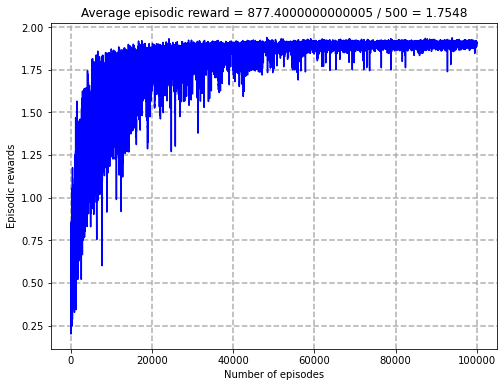

In [337]:
# compute moving average
window_size = 20
moving_averaged_rewards = list()
for idx in range(len(episode_rewards)):
    if idx+window_size < len(episode_rewards):
        average_reward = np.mean(episode_rewards[idx:idx+window_size])
        moving_averaged_rewards.append(average_reward)

robot_2.epsilon = 0. # disable exploration
test_episode_rewards = [agent_env_interaction(room_2, robot_2, train=False) for _ in range(500)]

fig = plt.figure(figsize=(8,6))
ax = fig.subplots(1,1)
ax.plot(moving_averaged_rewards, color='b', linewidth=1.5)
ax.grid(linestyle='--', linewidth=1.5)
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Episodic rewards')
ax.set_title('Average episodic reward = {} / {} = {}'.format(sum(test_episode_rewards), 
                                                              len(test_episode_rewards), np.mean(test_episode_rewards)));

#### 5.2.3. Robot Behavior Visualization <a id='section_523'></a>
You can also visualize the behaviors of your trained cleaning robot in the room by the following code block:  

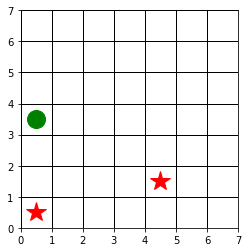

In [338]:
# robot clearning with single goal
state = room_2.reset()
for _ in range(100):
    action = robot_2.decide(state)
    state, reward, done = room_2.step(action)
    room_2.render()
    plt.pause(0.01)
    display.clear_output(wait=True)
    if done:
        state = room_2.reset()

### 5.3. Room with Obstacles and Two Cells to Clean <a id='section_53'></a>
#### 5.3.1. Training Environment Setting <a id='section_531'></a>
The learning task is to let the robot clean two target cells in a room with two obstacles. The environment will be configured to have two goals and two obstacles. In detail, you will:

**Task 8:** <a id='task_8'></a> 
##### Task 8(A)
1. create a `Room()` environment and save it in `room_3`. Please set the input `goal_num=` and `obstacle_num=` correctly. (1 line)
2. create a `QAgent()` robot and save it in `robot_3`. Please set the input `epsilon=` as 0.2 (you can also set another value later for comparison). (1 line)
##### Task 8(B)
3. get the reward of one episode with your implemented function `agent_env_interaction()`. Do not forget to set the input `train=` to be "True". Then, save the result in `episode_reward`. (1 line)

This part requires aproximately 7-10 minutes depending on your hardware.

In [335]:
episodes = 150000
# create environment
# task 8(A):
# ====================== START YOUR CODE HERE ======================
room_3 = Room(goal_num=2, obstacle_num=2)
robot_3 = QAgent(room_3, epsilon=0.2)
# ====================== END YOUR CODE HERE ========================
# training
episode_rewards = []
for episode in range(episodes):
    if episode % 1000 == 0:
        print("Episode: {}".format(episode))
    # task 8(B):
    # ====================== START YOUR CODE HERE ======================
    episode_reward = agent_env_interaction(room_3, robot_3, max_iter=50, train=True)
    # ====================== END YOUR CODE HERE ========================
    episode_rewards.append(episode_reward)

Episode: 0
Episode: 1000
Episode: 2000
Episode: 3000
Episode: 4000
Episode: 5000
Episode: 6000
Episode: 7000
Episode: 8000
Episode: 9000
Episode: 10000
Episode: 11000
Episode: 12000
Episode: 13000
Episode: 14000
Episode: 15000
Episode: 16000
Episode: 17000
Episode: 18000
Episode: 19000
Episode: 20000
Episode: 21000
Episode: 22000
Episode: 23000
Episode: 24000
Episode: 25000
Episode: 26000
Episode: 27000
Episode: 28000
Episode: 29000
Episode: 30000
Episode: 31000
Episode: 32000
Episode: 33000
Episode: 34000
Episode: 35000
Episode: 36000
Episode: 37000
Episode: 38000
Episode: 39000
Episode: 40000
Episode: 41000
Episode: 42000
Episode: 43000
Episode: 44000
Episode: 45000
Episode: 46000
Episode: 47000
Episode: 48000
Episode: 49000
Episode: 50000
Episode: 51000
Episode: 52000
Episode: 53000
Episode: 54000
Episode: 55000
Episode: 56000
Episode: 57000
Episode: 58000
Episode: 59000
Episode: 60000
Episode: 61000
Episode: 62000
Episode: 63000
Episode: 64000
Episode: 65000
Episode: 66000
Episode:

#### 5.3.2. Training Performance Visualization <a id='section_532'></a>
After training 150000 episodes, the average rewards of each episode are visualized by the following figure.The size of moving average window is 50 due to large vibration in more complex environment.

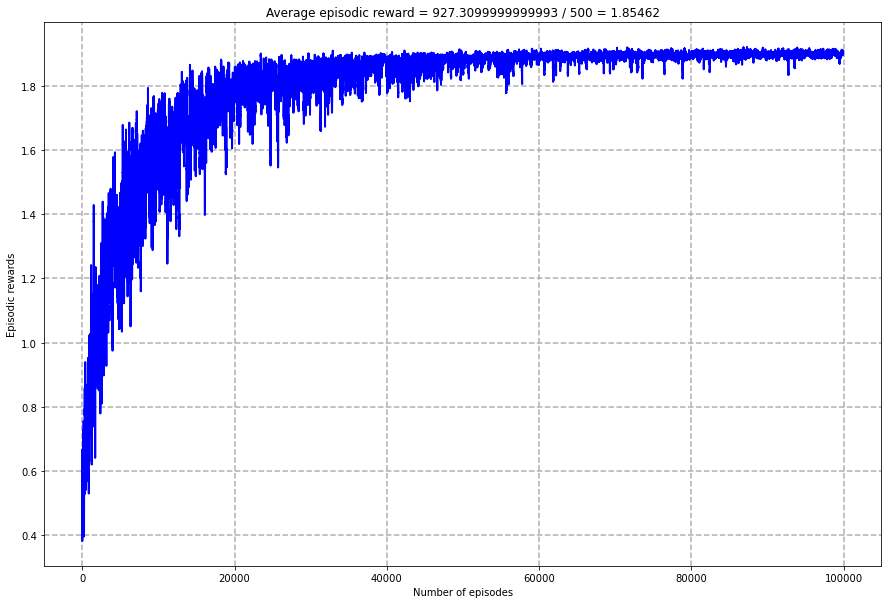

In [339]:
# compute moving average
window_size = 50
moving_averaged_rewards = list()
for idx in range(len(episode_rewards)):
    if idx+window_size < len(episode_rewards):
        average_reward = np.mean(episode_rewards[idx:idx+window_size])
        moving_averaged_rewards.append(average_reward)

robot_3.epsilon = 0. # disable exploration
test_episode_rewards = [agent_env_interaction(room_3, robot_3) for _ in range(500)]

fig = plt.figure(figsize=(15,10))
ax = fig.subplots(1,1)
ax.plot(moving_averaged_rewards, color='b', linewidth=2)
ax.grid(linestyle='--', linewidth=1.5)
ax.set_xlabel('Number of episodes')
ax.set_ylabel('Episodic rewards')
ax.set_title('Average episodic reward = {} / {} = {}'.format(sum(test_episode_rewards), 
                                                              len(test_episode_rewards), np.mean(test_episode_rewards)));

#### 5.3.3. Robot Behavior Visualization <a id='section_533'></a>
You can also visualize the behaviors of your trained cleaning robot in the room by the following code block:  

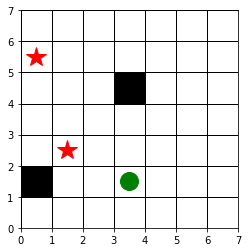

In [340]:
# robot clearning with single goal
state = room_3.reset()
for _ in range(100):
    action = robot_3.decide(state)
    state, reward, done = room_3.step(action)
    room_3.render()
    plt.pause(0.01)
    display.clear_output(wait=True)
    if done:
        state = room_3.reset()

Comparing the three learning scenarios, you should notice the following:
* The epsilon-greedy algorithm balances between exploration and exploitation by using the probabilities ε and 1 − ε respectively.
* A simple environment (as in [Section 5.1](#section_51)) with no obstacle and only one cell to clean requires fewer than 10000 learning episode to achieve convergence.
* As the environment becomes more complex (as in [Section 5.2](#section_52) and [Section 5.3](#section_53)), the number of episodes required to find the maximum rewards increases exponentially.

## 6. Marking Scheme and Submission <a id='section_6'></a>

This part carries 30% of the assignment grade. Part A (clustering) carries 50%. The Quiz posted on Moodle carries 20%. Late submission will incur a 30% deduction. The marking scheme of this part follows.

**Task Summary**

| Task | Grade Points 
|:----|:----:         
| 1. Parameter Initialization ([`QAgent.__init__()`](#task_1)) | 3
| 2. Action Sampling ([`QAgent.decide()`](#task_2)) | 4
| 3. Q-Learning Function ([`QAgent.learn()`](#task_3)) | 6
| 4. Agent-Environment Interaction ([`agent_env_interaction()`](#task_4)) | 5
| 5. Learning Process ([`agent_env_interaction()`](#task_5)) | 3
| 6. [Empty Room with One Cell to Clean](#task_6) | 3
| 7. [Empty Room with Two Cells to Clean](#task_7) | 3
| 8. [Room with Obstacles and Two Cells to Clean](#task_8) | 3
| **TOTAL** | **30**

### Submission
You are required to upload to Moodle a zip file containing the following files.

1. Your completed Jupyter Notebook of this part. Please rename your file as `A3B_[SID]_[FirstnameLastname].ipynb` (where `[SID]` is your student ID and `[FirstnameLastname]` is your first name and last name concatenated) and do not include the data file. You must complete the **Acknowledgment** section in order for the file to be graded.
2. The PDF version (.pdf file) of your completed notebook (click `File > Download as > PDF via HTML` (If error occurs, you may download it as HTML and then save the HTML as PDF separately)).

In addition, please complete **A3Q: Assignment 3 -- Quiz** separately on the Moodle site.

## 7. Summary <a id='section_7'></a>
Congratulations! You have implemented the Q-learning algorithm to enable a robot to clean a room using reinforcement learning! To summarize, you have implemented the Q-agent and the interaction process between agent and environment. Your program has evaluated the agent's learning in three different environments and has produced visualizations of the reward and robot behavior. 